In [ ]:
!pip install jamo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Embedding, RepeatVector, Concatenate, Reshape, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy.io.wavfile import read, write
import librosa
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_path = '/content/drive/MyDrive/dataset/voice/ljs_audio_text_train_filelist.txt'
val_data_path =  '/content/drive/MyDrive/dataset/voice/ljs_audio_text_val_filelist.txt'
wav_path = '/content/drive/MyDrive/dataset/voice/'

In [ ]:
import random

def load_data(file_path, wav_path, subset_ratio=None):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if subset_ratio:
            random.shuffle(lines)
            num_samples = int(len(lines) * subset_ratio)
            lines = lines[:num_samples]
        for line in lines:
            wav_file, text = line.strip().split("|")
            wav_file_path = os.path.join(wav_path, wav_file[10:])
            audio, _ = librosa.load(wav_file_path, sr=None)
            data.append((audio, text))
    return data

In [ ]:
# 데이터셋이 많아 학습 및 로딩시간이 매우 기므로 20%만 랜덤 추출 (시험용)

train_data = load_data(train_data_path, wav_path, subset_ratio=0.2)
val_data = load_data(val_data_path, wav_path, subset_ratio=0.2)

In [ ]:
# 한글을 초성 중성 종성으로 분리한 후 각각 숫자로 임베딩

import re
import unicodedata

CHOSUNGS = "".join([chr(_) for _ in range(0x1100, 0x1113)])
JOONGSUNGS = "".join([chr(_) for _ in range(0x1161, 0x1176)])
JONGSUNGS = "".join([chr(_) for _ in range(0x11A8, 0x11C3)])
ALPHABETS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
NUMBERS = "0123456789"
SPECIALS = " ?!"

ALL_VOCABS = "".join([
    CHOSUNGS,
    JOONGSUNGS,
    JONGSUNGS,
    ALPHABETS,
    NUMBERS,
    SPECIALS
])
VOCAB_DICT = {
    "_": 0,
    "~": 1,
}

for idx, v in enumerate(ALL_VOCABS):
    VOCAB_DICT[v] = idx + 2


def normalize(text):
    text = unicodedata.normalize('NFKD', text)
    text = text.upper()
    text = text.replace('%', unicodedata.normalize('NFKD', '퍼센트'))
    regex = unicodedata.normalize('NFKD', r"[^ \u11A8-\u11FF\u1100-\u115E\u1161-\u11A70-9A-Z?!]")
    text = re.sub(regex, '', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text


def tokenize(text, encoding: bool = True):
    tokens = list()

    for t in text:
        if encoding:
            tokens.append(VOCAB_DICT[t])
        else:
            tokens.append(t)

    if encoding:
        tokens.append(VOCAB_DICT['~'])
    else:
        tokens.append('~')

    return tokens


def text_to_sequence(text):
    text = normalize(text)
    tokens = tokenize(text, encoding=True)
    return tokens

# Example usage
text = "안녕하세요"
embedding = text_to_sequence(text)
print(embedding)

[13, 21, 45, 4, 27, 62, 20, 21, 11, 26, 13, 33, 1]


In [ ]:
from keras.utils import pad_sequences

# Preprocess data(text)
train_wavs, train_texts = zip(*train_data)
val_wavs, val_texts = zip(*val_data)

max_audio_length = 200
output_dim = 400

# Convert text to sequence
train_texts = [text_to_sequence(text) for text in train_texts]
val_texts = [text_to_sequence(text) for text in val_texts]

# Padding sequences for train and val texts
train_texts = pad_sequences(train_texts, dtype='int32', padding='post', maxlen=140)
val_texts = pad_sequences(val_texts, dtype='int32', padding='post', maxlen=140)

# Expanding the dimension of the text data
train_texts = np.expand_dims(train_texts, axis=1)
val_texts = np.expand_dims(val_texts, axis=1)

In [ ]:
# Padding and reshaping train and val wavs
train_wavs_mel = []
for audio in train_wavs:
    if len(audio.shape) == 1:
        audio = audio[:80000]  # Cut if size exceeds 80000
        audio = np.pad(audio, (0, max(0, 80000 - len(audio))))  # Pad if size is less than 80000
        audio = audio.reshape(-1, 400)[:200, :]  # Reshape to 2D and cut to fit into (200, 400)
    train_wavs_mel.append(audio)

val_wavs_mel = []
for audio in val_wavs:
    if len(audio.shape) == 1:
        audio = audio[:80000]  # Cut if size exceeds 80000
        audio = np.pad(audio, (0, max(0, 80000 - len(audio))))  # Pad if size is less than 80000
        audio = audio.reshape(-1, 400)[:200, :]  # Reshape to 2D and cut to fit into (200, 400)
    val_wavs_mel.append(audio)

train_wavs_mel = np.array(train_wavs_mel)
val_wavs_mel = np.array(val_wavs_mel)

In [ ]:
max_text_length = 140 # 최대 문장 길이
vocab_size = 10000 # 단어 사전 크기
embedding_dim = 256 # 임베딩 차원
latent_dim = 64 # 잠재 공간 차원
output_length = 100 # 출력 길이
output_dim = 400  # 출력 차원
max_audio_length = 200   # 음성 길이

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention

def create_tts_model(input_dim_text, input_dim_audio, hidden_dim, num_heads):
    # Define inputs
    text_input = Input(shape=(1, input_dim_text), name="text_input")
    audio_input = Input(shape=(200, input_dim_audio), name="audio_input")

    # Use LSTM to map text_input to the same dimension as audio_input
    text_mapped = LSTM(input_dim_audio, return_sequences=True)(text_input)

    # Transformer encoder
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)(text_mapped, audio_input)
    attention = LayerNormalization(epsilon=1e-6)(attention + audio_input)
    output = Dense(input_dim_audio)(attention)

    model = Model(inputs=[text_input, audio_input], outputs=output)
    
    return model

# Create the TTS model
tts_model = create_tts_model(input_dim_text=140, input_dim_audio=400, hidden_dim=64, num_heads=2)
tts_model.compile(optimizer='adam', loss='mse')

In [ ]:
# 모델 생성
model = tts_model
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 1, 140)]     0           []                               
                                                                                                  
 lstm_26 (LSTM)                 (None, 1, 400)       865600      ['text_input[0][0]']             
                                                                                                  
 audio_input (InputLayer)       [(None, 200, 400)]   0           []                               
                                                                                                  
 multi_head_attention_10 (Multi  (None, 1, 400)      205584      ['lstm_26[0][0]',                
 HeadAttention)                                                   'audio_input[0][0]']     

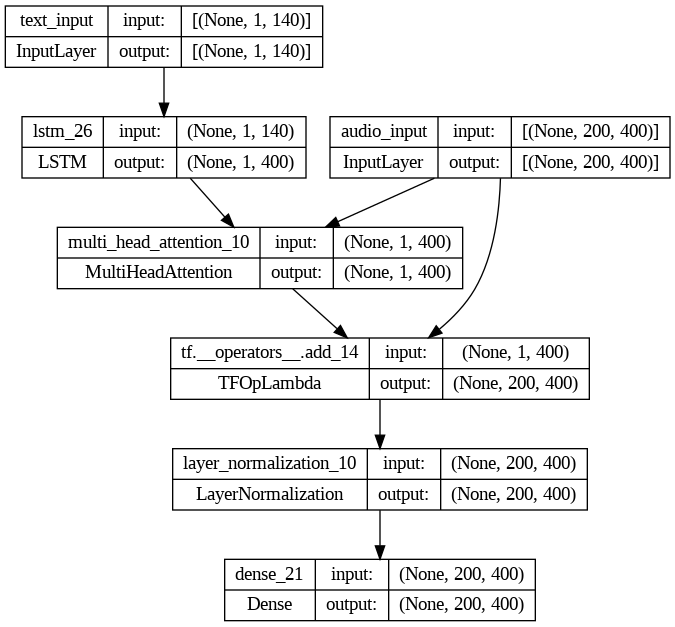

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
text_data = np.array(train_texts, dtype=np.float32).reshape((-1, 1, 140))
val_text_data = np.array(val_texts, dtype=np.float32).reshape((-1, 1, 140))
audio_data = train_wavs_mel
val_audio_data = val_wavs_mel

# Training the model
tts_model.fit([text_data, audio_data], audio_data, epochs=100, batch_size=32, validation_data=([val_text_data, val_audio_data], val_audio_data))

Epoch 1/100
19/19 [==============================] - 12s 425ms/step - loss: 0.4280 - val_loss: 0.1457
Epoch 2/100
19/19 [==============================] - 6s 310ms/step - loss: 0.0796 - val_loss: 0.0132
Epoch 3/100
19/19 [==============================] - 7s 397ms/step - loss: 0.0095 - val_loss: 0.0060
Epoch 4/100
19/19 [==============================] - 5s 275ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 5/100
19/19 [==============================] - 7s 382ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 6/100
19/19 [==============================] - 5s 276ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 7/100
19/19 [==============================] - 5s 264ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/100
19/19 [==============================] - 7s 378ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 9/100
19/19 [==============================] - 6s 301ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/100
19/19 [==============================] - 7s 397ms/step - loss: 0.0034 - val_l

In [ ]:
tts_model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# import matplotlib.pyplot as plt

# # Save loss and validation loss data
# np.savez("loss_history.npz", loss=history.history['loss'], val_loss=history.history['val_loss'])

# # Plot the loss and validation loss curves
# epochs = range(1, len(history.history['loss']) + 1)

# plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
# plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig("loss_curve.png")
# plt.show();

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Flatten
from tensorflow.keras import backend as K

# def create_text_to_voice_model(input_dim_text, hidden_dim, num_heads):
#     # Define the input for text
#     text_input = Input(shape=(1, input_dim_text), name="text_input")

#     # Use the "text-to-voice" model layers up to the attention layer
#     text_mapped = tts_model.get_layer("lstm_8")(text_input)
#     attention = tts_model.get_layer("multi_head_attention_9")(text_mapped, tts_model.get_layer("audio_input")(text_mapped))
#     attention = tts_model.get_layer("layer_normalization_9")(attention)

#     # Adjust the time dimension to match the desired shape
#     output = Lambda(lambda x: K.repeat_elements(x, 200, axis=1))(attention)

#     # Create the model
#     model = Model(inputs=text_input, outputs=output)

#     # Set the pre-trained model's layers as non-trainable and transfer the weights
#     for layer in model.layers:
#         if layer.name in tts_model.layers:
#             layer.set_weights(tts_model.get_layer(layer.name).get_weights())
#             layer.trainable = False

#     return model

def create_text_to_voice_model(input_dim_text, hidden_dim, output_sequence_length, output_feature_dim, pretrained_model_path):
    # Load the pretrained model
    pretrained_model = keras.models.load_model(pretrained_model_path)

    # Create a new input for the text data
    text_input = Input(shape=(1, input_dim_text), name="text_input")

    # Pass the text input through the pretrained model's LSTM and attention layers
    lstm_output = pretrained_model.get_layer("lstm_26")(text_input)
    attention_output = pretrained_model.get_layer("multi_head_attention_10")(lstm_output, lstm_output)
    normalized_output = pretrained_model.get_layer("layer_normalization_10")(attention_output)

    # Add a new LSTM layer with the specified hidden dimension
    lstm_layer = LSTM(hidden_dim, return_sequences=True)(normalized_output)

    # Apply Dense layer to each time step
    dense_output = TimeDistributed(Dense(output_feature_dim))(lstm_layer)

    # Repeat the output sequence length using a Lambda layer
    repeated_output = Lambda(lambda x: K.repeat_elements(x, output_sequence_length, axis=1))(dense_output)

    # Create a model with the text input and the repeated output
    model = Model(text_input, repeated_output)

    return model

In [ ]:
text_to_voice_model = create_text_to_voice_model(input_dim_text=140, hidden_dim=64, output_sequence_length=200, output_feature_dim=400, pretrained_model_path='my_model.h5')
text_to_voice_model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 1, 140)]     0           []                               
                                                                                                  
 lstm_26 (LSTM)                 (None, 1, 400)       865600      ['text_input[0][0]']             
                                                                                                  
 multi_head_attention_10 (Multi  (None, 1, 400)      205584      ['lstm_26[1][0]',                
 HeadAttention)                                                   'lstm_26[1][0]']                
                                                                                                  
 layer_normalization_10 (LayerN  multiple            800         ['multi_head_attention_10[

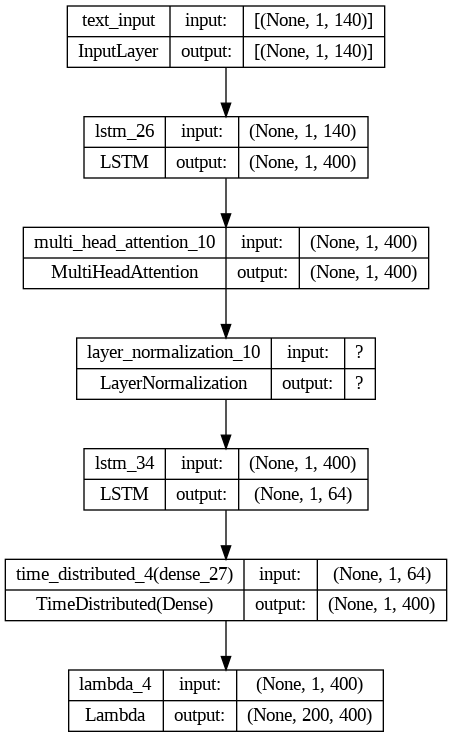

In [ ]:
keras.utils.plot_model(text_to_voice_model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt

# Create an instance of History callback
history = History()

text_to_voice_model.compile(optimizer='adam', loss='mse')
text_to_voice_model.fit(text_data, audio_data, epochs=100, batch_size=32, validation_data=(val_text_data, val_audio_data), callbacks=[history])

Epoch 1/100
19/19 [==============================] - 10s 161ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 2/100
19/19 [==============================] - 1s 61ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 3/100
19/19 [==============================] - 1s 61ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 4/100
19/19 [==============================] - 1s 60ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 5/100
19/19 [==============================] - 1s 46ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 6/100
19/19 [==============================] - 1s 46ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 7/100
19/19 [==============================] - 1s 46ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/100
19/19 [==============================] - 1s 52ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 9/100
19/19 [==============================] - 2s 87ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 10/100
19/19 [==============================] - 2s 90ms/step - loss: 0.0064 - val_loss: 0.00

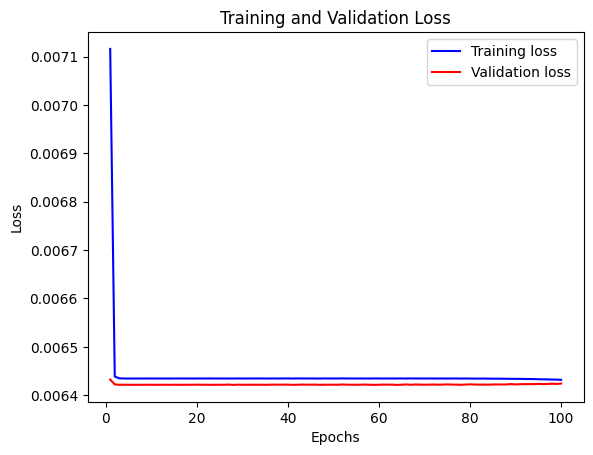

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and val_loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def generate_speech(text, model):
    # Preprocess the input text
    input_text = pad_sequences([text_to_sequence(text)], dtype='int32', padding='post', maxlen=140)
    input_text = np.expand_dims(input_text, axis=1)

    generated_speech = model.predict([input_text])

    return generated_speech

# Use the function to generate speech
text = "안녕하세요 반갑습니다. 저는 발표자입니다."
generated_speech = generate_speech(text, text_to_voice_model)

1/1 [==============================] - 1s 1s/step


In [ ]:
generated_speech.flatten().shape

(80000,)

In [ ]:
generated_speech.T

array([[[ 0.00013245],
        [ 0.00013245],
        [ 0.00013245],
        ...,
        [ 0.00013245],
        [ 0.00013245],
        [ 0.00013245]],

       [[ 0.00216484],
        [ 0.00216484],
        [ 0.00216484],
        ...,
        [ 0.00216484],
        [ 0.00216484],
        [ 0.00216484]],

       [[-0.00031283],
        [-0.00031283],
        [-0.00031283],
        ...,
        [-0.00031283],
        [-0.00031283],
        [-0.00031283]],

       ...,

       [[ 0.00104678],
        [ 0.00104678],
        [ 0.00104678],
        ...,
        [ 0.00104678],
        [ 0.00104678],
        [ 0.00104678]],

       [[ 0.00123615],
        [ 0.00123615],
        [ 0.00123615],
        ...,
        [ 0.00123615],
        [ 0.00123615],
        [ 0.00123615]],

       [[ 0.00087974],
        [ 0.00087974],
        [ 0.00087974],
        ...,
        [ 0.00087974],
        [ 0.00087974],
        [ 0.00087974]]], dtype=float32)

In [ ]:
import soundfile as sf
reshaped_array = generated_speech.flatten()
mp3_file_path = "/content/drive/MyDrive/generated_voice_5.mp3"  # Replace with the desired output file path
sf.write(mp3_file_path, reshaped_array, 22050, format='mp3')